<center>
<img src="https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/images/bogdanoff_cover.jpeg" height="150">

# Андан на экономе: домашнее задание 2
</center>


> [He bought? Dump it. He sold? Pump it.](https://www.youtube.com/watch?v=fDpYZU5FAVU)  <br>

$\qquad$ $\qquad$ $\qquad$ $\qquad$  📉 📉 📉**Bogdanoff**


In [1]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

#  Портфельная теория Марковица

В этом задании мы будем работать с данными по ценным бумагам. Мы немного поанализируем их и попробуем собрать оптимальный портфель.

- в таблице `stocks.csv` содержится информация об акциях нескольких компаний с $01.01.2014$ по $31.12.2023$ по дням.
- таблице `exchange_rates.csv` содержится информация о курсах валют _USD-RUB_, _EUR-RUB_ и _HKD-RUB_ за тот же период.

Подгрузим данные и посмотрим на них.

In [3]:
df_stocks = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/data/stocks.csv')
print(df_stocks.shape)
df_stocks.head()

(17572, 8)


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,29.12.2023,"192,53","193,90","194,40","191,73","42,67M","-0,54%",AAPL
1,28.12.2023,"193,58","194,14","194,66","193,17","33,83M","0,22%",AAPL
2,27.12.2023,"193,15","192,49","193,50","191,09","47,90M","0,05%",AAPL
3,26.12.2023,"193,05","193,61","193,89","192,83","28,81M","-0,28%",AAPL
4,22.12.2023,"193,60","195,18","195,41","192,97","37,15M","-0,55%",AAPL


In [4]:
df_rates = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/data/exchange_rates.csv')
print(df_rates.shape)
df_rates.head()

(3652, 4)


,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,01.01.2014,"45,189","32,855","4,237"
1,02.01.2014,"45,254","33,1","4,269"
2,03.01.2014,"45,114","33,2","4,282"
3,04.01.2014,"45,125","33,248","4,288"
4,05.01.2014,"45,228","33,255","4,289"


## 1 Причешем данные

Часто при загрузке данных из каких-либо источников, особенно если они разные, у вас будет возникать необходимость в их форматировании. Поэтому в этой части потренируемся корректировать переменные для последующей работы с ними.


__а) [2 балла]__ В колонке `'Дата'` лежат дни, в которые осуществлялась торговля акциями. Превратите её в формат `datetime` в обеих таблицах.

In [5]:
df_stocks['Дата'] = pd.to_datetime(df_stocks['Дата'],format = '%d.%m.%Y')
#df_stocks['Дата'] = pd.to_datetime(df_stocks['Дата'].dt.strftime(date_format = '%d/%m/%Y'))


df_rates['Дата'] = pd.to_datetime(df_rates['Дата'],format = '%d.%m.%Y')
#df_rates['Дата'] = pd.to_datetime(df_rates['Дата'].dt.strftime(date_format = '%d/%m/%Y'))

In [6]:
df_rates.head()

,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,2014-01-01,"45,189","32,855","4,237"
1,2014-01-02,"45,254","33,1","4,269"
2,2014-01-03,"45,114","33,2","4,282"
3,2014-01-04,"45,125","33,248","4,288"
4,2014-01-05,"45,228","33,255","4,289"


In [7]:
#проверка того, что теперь тип - datetime
df_stocks.dtypes

Дата      datetime64[ns]
Цена              object
Откр.             object
Макс.             object
Мин.              object
Объём             object
Изм. %            object
Тикер             object
dtype: object

__б) [5 баллов]__ Для продолжения работы необходимо перевести столбцы в числовой формат, однако они содержат некорректные символы, которые не позволят сделать это напрямую.

Допишите функцию, которая примет на вход тип данных `string` и:

- Уберет лишнюю точку, разделяющую тысячные разряды в числах (например, $2.024,01 \rightarrow 2024,01$)
- Заменит символ запятой, отделяющий десятичный разряд, на точку (например, $2024,01 \rightarrow 2024.01$)
- Уберет символы `%`, `'B'` (млрд), `'M'` (млн) и `'K'` (тыс)
- Затем изменит тип данных с `string` на `float`
- И домножит на $10^9$, если в исходном значении содержалась `'B'`, на $10^6$, если `'M'`, или на $10^3$, если `'K'`.

In [8]:
def correct_values(value: str):

    corrected_value = value.replace('.', '').replace(',', '.').replace('%', '').replace('B', '').replace('M', '').replace('K', '')
    corrected_value = float(corrected_value)

    if 'B' in value:
        corrected_value *= 10**9
    elif 'M' in value:
        corrected_value *= 10**6
    elif 'K' in value:
        corrected_value *= 10**3

    return corrected_value

Примените данную функцию к столбцам `'Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %'` таблицы `df_stocks` и к столбцам `'EUR_RUB', 'USD_RUB', 'HKD_RUB'` таблицы `df_rates`.

__Hint:__ Для этого можно использовать метод `map` библиотеки `pandas`. Важно также указать параметр `na_action='ignore'`, чтобы пустые значения не передавались в функцию `correct_values`, [(ссылка на документацию).](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html)

In [9]:
df_stocks['Цена'] = df_stocks['Цена'].map(correct_values, na_action='ignore')
df_stocks['Откр.'] = df_stocks['Откр.'].map(correct_values, na_action='ignore')
df_stocks['Макс.'] = df_stocks['Макс.'].map(correct_values, na_action='ignore')
df_stocks['Мин.'] = df_stocks['Мин.'].map(correct_values, na_action='ignore')
df_stocks['Изм. %'] = df_stocks['Изм. %'].map(correct_values, na_action='ignore')
df_stocks['Объём'] = df_stocks['Объём'].map(correct_values, na_action='ignore')

In [10]:
df_rates['EUR_RUB'] = df_rates['EUR_RUB'].map(correct_values, na_action='ignore')
df_rates['USD_RUB'] = df_rates['USD_RUB'].map(correct_values, na_action='ignore')
df_rates['HKD_RUB'] = df_rates['HKD_RUB'].map(correct_values, na_action='ignore')

__в) [5 баллов]__ Поскольку акции компаний торгуются на разных биржах, цены также указаны в различных валютах.
Давайте приведем все к рублям, используя таблицу `df_rates`. Для этого важно знать, что данные по тикерам:

- `'AAPL'` и `'MSFT'` собраны в долларах `USD`
- `'MBGn'` и `'BMWG'` $-$ в евро `EUR`
- `'Tencent'` $-$ в Гонконгских долларах `HKD`
- по остальным $-$ в `RUB`

Давайте сначала объединим таблицы, выполнив операцию `left join` таблицы `df_stocks` с `df_rates` по столбцу `'Дата'`. Для этого будем использовать метод `merge`, [(ссылка на документацию).](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

In [11]:
df_merged = df_stocks.merge(df_rates, how = 'left', on = 'Дата')

df_merged.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,192.53,193.90,194.40,191.73,42670000.0,-0.54,AAPL,98.596,90.36,11.429
1,2023-12-28,193.58,194.14,194.66,193.17,33830000.0,0.22,AAPL,97.919,89.36,11.325
2,2023-12-27,193.15,192.49,193.50,191.09,47900000.0,0.05,AAPL,101.779,91.27,11.731
3,2023-12-26,193.05,193.61,193.89,192.83,28810000.0,-0.28,AAPL,101.455,91.66,11.734
4,2023-12-22,193.60,195.18,195.41,192.97,37150000.0,-0.55,AAPL,101.467,92.00,11.791


 Затем преобразуем столбцы `'Цена', 'Откр.', 'Макс.', 'Мин.'`, умножив их на соответствующий данной акции курс.

In [12]:
stocks_currency_dict = {
    "AAPL": "USD_RUB",
    "MSFT": "USD_RUB",
    "MBGn": "EUR_RUB",
    "BMWG": "EUR_RUB",
    "Tencent": "HKD_RUB",
}

for ticker, curr_pair in stocks_currency_dict.items():
    df_merged.loc[df_merged['Тикер'] == ticker, ['Цена', 'Откр.', 'Макс.', 'Мин.']] = df_merged.loc[df_merged['Тикер'] == ticker, ['Цена', 'Откр.', 'Макс.', 'Мин.']].to_numpy() * df_merged.loc[df_merged['Тикер'] == ticker, [curr_pair]].to_numpy()

df_merged.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,17397.0108,17520.8040,17565.9840,17324.7228,42670000.0,-0.54,AAPL,98.596,90.36,11.429
1,2023-12-28,17298.3088,17348.3504,17394.8176,17261.6712,33830000.0,0.22,AAPL,97.919,89.36,11.325
2,2023-12-27,17628.8005,17568.5623,17660.7450,17440.7843,47900000.0,0.05,AAPL,101.779,91.27,11.731
3,2023-12-26,17694.9630,17746.2926,17771.9574,17674.7978,28810000.0,-0.28,AAPL,101.455,91.66,11.734
4,2023-12-22,17811.2000,17956.5600,17977.7200,17753.2400,37150000.0,-0.55,AAPL,101.467,92.00,11.791


Наконец, мы закончили с первичными преобразованиями и можем приступать к дальнейшему анализу.

## 2 Начало работы с данными

__а) [2 балла]__ Посмотрите наличие пропусков в данных таблицы `df_merged`. Информация по каким тикерам и за какой период отсутствует? Удалите строки с пропущенными данными.

In [13]:
df_merged.isna().sum()

Дата       0
Цена       0
Откр.      0
Макс.      0
Мин.       0
Объём      9
Изм. %     0
Тикер      0
EUR_RUB    0
USD_RUB    0
HKD_RUB    0
dtype: int64

In [20]:
#более подробная информация о пропусках
df_merged[df_merged['Объём'].isna()]

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
1974,2016-02-27,7441.30030,7441.30030,7441.30030,7441.30030,NaN,300.12,AAPL,83.492,76.754,9.891
2800,2022-11-21,5195.40560,5214.67086,5238.90780,5191.05538,NaN,-0.65,BMWG,62.146,60.850,7.849
2944,2022-05-03,5745.28332,5618.13714,5745.28332,5593.71358,NaN,3.01,BMWG,71.834,70.960,8.697
2945,2022-05-02,5760.65508,5768.07478,5820.75465,5517.28892,NaN,-1.11,BMWG,74.197,73.440,9.006
7838,2022-11-21,3847.45886,3833.16528,3882.26062,3825.08630,NaN,-0.50,MBGn,62.146,60.850,7.849
7981,2022-05-04,4377.31124,4422.25716,4443.32556,4374.50212,NaN,-0.87,MBGn,70.228,66.300,8.425
7982,2022-05-03,4516.92192,4476.69488,4517.64026,4424.97440,NaN,1.06,MBGn,71.834,70.960,8.697
7988,2022-04-25,5181.59174,5173.47394,5227.86320,5110.96688,NaN,-1.39,MBGn,81.178,73.125,9.560
17313,2015-01-17,1037.63200,1037.63200,1037.63200,1037.63200,NaN,4.82,Tencent,75.166,64.942,8.368


In [22]:
#информация о каких тикерах отсутствует
df_merged[df_merged['Объём'].isna()]['Тикер'].unique()

array(['AAPL', 'BMWG', 'MBGn', 'Tencent'], dtype=object)

In [27]:
##информация по каким датам отсутствует
df_merged[df_merged['Объём'].isna()]['Дата'].dt.date.unique()

array([datetime.date(2016, 2, 27), datetime.date(2022, 11, 21),
       datetime.date(2022, 5, 3), datetime.date(2022, 5, 2),
       datetime.date(2022, 5, 4), datetime.date(2022, 4, 25),
       datetime.date(2015, 1, 17)], dtype=object)

In [28]:
#удаление пропусков
df_merged = df_merged.dropna()
df_merged.reset_index(inplace=True, drop=True)
df_merged.isna().sum()

Дата       0
Цена       0
Откр.      0
Макс.      0
Мин.       0
Объём      0
Изм. %     0
Тикер      0
EUR_RUB    0
USD_RUB    0
HKD_RUB    0
dtype: int64

__Итог:__ Информация больше всего отсутствует за 2022 год, а именно, месяца: май, апрель, ноябрь. Также за один день в феврале 2016 и один день в январе 2015 по акциям AAPL и Tencent соответственно.   Больше всего информации отсутствует по акции MBGn

__б) [2 балла]__ Какое количество уникальных тикеров содержится в таблице `df_stocks`?

In [29]:
#df_stocks['Тикер'].unique()
print(f'Уникальных тикеров: ', len(df_stocks['Тикер'].unique()))

Уникальных тикеров:  7


__в) [2 балла]__  Для каких акций и в какой временной период была зафиксирована наибольшая разность между значениями `'Макс.'` и `'Мин.'` в рублях?

In [30]:
#акция с наибольшей разностью
mx = np.max(df_merged['Макс.'] - df_merged['Мин.'])
print(f'Наибольшая разность = {mx}')
print('Акция:' ,df_merged.loc[df_merged['Макс.'] - df_merged['Мин.'] == mx, ['Тикер']].to_numpy()[0][0])
print('Дата: ', df_merged.loc[df_merged['Макс.'] - df_merged['Мин.'] == mx]['Дата'].dt.date.to_numpy()[0])
print('Вся информация:')
df_merged[df_merged['Макс.'] - df_merged['Мин.'] == mx]

Наибольшая разность = 2237.048999999992
Акция: MSFT
Дата:  2023-07-18
Вся информация:


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
10197,2023-07-18,32677.641,31435.947,33340.302,31103.253,64520000.0,3.98,MSFT,102.184,90.9,11.613


In [33]:
#Топ 10 по наибольшей разности
df_merged_temp = df_merged.copy()
df_merged_temp['Разность'] = df_merged_temp['Макс.'] - df_merged_temp['Мин.']
df_merged_temp.sort_values(by = 'Разность', ascending = False)[:10]

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB,Разность
10197,2023-07-18,32677.64100,31435.94700,33340.30200,31103.25300,64520000.0,3.98,MSFT,102.184,90.900,11.613,2237.04900
10546,2022-02-24,24759.70032,22903.92048,24807.60768,22820.71296,56990000.0,5.11,MSFT,95.207,84.048,10.764,1986.89472
10538,2022-03-08,35170.87500,35419.50000,36204.90000,34425.00000,48160000.0,-1.10,MSFT,118.993,127.500,16.307,1779.90000
10568,2022-01-24,23349.80682,23021.26920,23408.10846,21748.87530,86040000.0,0.11,MSFT,89.234,78.786,10.090,1659.23316
10539,2022-03-07,39884.13000,41259.79000,41425.67000,39829.79000,43160000.0,-3.78,MSFT,118.993,143.000,18.288,1595.88000
11038,2020-03-13,11533.12279,10710.41750,11756.77083,10218.82749,92730000.0,14.22,MSFT,80.687,72.613,9.301,1537.94334
10126,2023-10-26,30808.54440,31997.13840,32099.55480,30719.28240,37230000.0,-3.75,MSFT,98.932,93.960,11.974,1380.27240
10140,2023-10-06,32857.23126,31781.93655,33051.00519,31756.83630,25670000.0,2.47,MSFT,106.924,100.401,12.896,1294.16889
10574,2022-01-13,23248.92480,24444.16972,24475.44288,23187.90400,45370000.0,-4.23,MSFT,87.348,76.276,9.801,1287.53888
10170,2023-08-24,30353.95405,31575.81525,31588.14770,30353.00540,21480000.0,-2.15,MSFT,102.427,94.865,12.050,1235.14230


In [34]:
mx = np.sort(df_merged['Макс.'] - df_merged['Мин.'])[-10:]
print('Акция:', df_merged[(df_merged['Макс.'] - df_merged['Мин.']).isin(mx)]['Тикер'].unique()[0])
print('Даты: ')
print(*np.sort((df_merged[(df_merged['Макс.'] - df_merged['Мин.']).isin(mx)]['Дата'].dt.date.unique())), sep = '\n')

Акция: MSFT
Даты: 
2020-03-13
2022-01-13
2022-01-24
2022-02-24
2022-03-07
2022-03-08
2023-07-18
2023-08-24
2023-10-06
2023-10-26


__Итог:__ В основном временной период охватывает начало 2022 и начало второй половины 2023 года по акции MSFT

__г) [2 балла]__  В какие периоды было продано/куплено акций на наибольшую сумму рублей. Какие это были акции?

__Hint__: Объем — это количество проданных/купленных акций

In [35]:
df_merged_temp = df_merged.copy()
df_merged_temp['Стоимость'] = df_merged_temp['Объём'] * df_merged_temp['Цена']
df_merged_temp.sort_values(by = 'Стоимость', ascending = False)[:10]

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB,Стоимость
843,2020-08-24,9394.19040,9606.16800,9612.13920,9250.88160,345940000.0,1.20,AAPL,87.965,74.640,9.610,3.249826e+12
844,2020-08-21,9302.87600,8920.64800,9340.27600,8919.90000,338050000.0,5.15,AAPL,88.214,74.800,9.644,3.144837e+12
834,2020-09-04,9121.47264,9054.35863,9328.09330,8362.10401,332610000.0,0.07,AAPL,89.250,75.409,9.703,3.033893e+12
859,2020-07-31,7906.91286,7655.40368,7918.81862,7502.86113,374300000.0,10.47,AAPL,87.555,74.411,9.576,2.959557e+12
456,2022-03-08,20073.60000,20249.55000,20767.20000,19864.50000,131150000.0,-1.17,AAPL,118.993,127.500,16.307,2.632653e+12
10091,2023-12-15,33467.65075,33117.38375,33618.41000,33065.92700,78500000.0,1.31,MSFT,98.547,90.275,11.617,2.627211e+12
510,2021-12-17,12687.12162,12597.42069,12859.85151,12579.62877,195920000.0,-0.65,AAPL,83.361,74.133,9.488,2.485661e+12
858,2020-08-03,7965.14810,7911.04300,8162.55860,7888.37735,308150000.0,2.52,AAPL,86.018,73.115,9.412,2.454460e+12
808,2020-10-13,9330.63390,9651.92823,9661.17411,9218.91285,262330000.0,-2.65,AAPL,90.470,77.049,9.921,2.447705e+12
482,2022-01-28,13256.44324,12896.87788,13257.99980,12670.39840,179940000.0,6.98,AAPL,86.795,77.828,10.019,2.385364e+12


In [41]:
#неотсортированный вариант
#mx = np.sort(df_merged['Объём'] * df_merged['Цена'])[-10:]
#df_merged[(df_merged['Объём'] * df_merged['Цена']).isin(mx)]

In [40]:
mx = np.sort(df_merged['Объём'] * df_merged['Цена'])[-10:]
print('Акция:', df_merged[(df_merged['Объём'] * df_merged['Цена']).isin(mx)]['Тикер'].unique())
print('Даты: ')
print(*np.sort((df_merged[(df_merged['Объём'] * df_merged['Цена']).isin(mx)]['Дата'].dt.date.unique())), sep = '\n')

Акция: ['AAPL' 'MSFT']
Даты: 
2020-07-31
2020-08-03
2020-08-21
2020-08-24
2020-09-04
2020-10-13
2021-12-17
2022-01-28
2022-03-08
2023-12-15


__Итог:__ Акции AAPL и MSFT, временной период в основном охватывает дни в начале второй половины 2020 года.

__д) [5 баллов]__  В столбике `'Изм. %'` лежат изменения стоимости ценных бумаг в процентах. При этом для каждой бумаги валюта своя.

Найдите 5 дат, в которые наблюдались наибольшие средние процентные изменения стоимости акций в абсолютном выражении.

__Hint:__ От изменения акций надо взять модуль, а затем посчитать среднее по тикерам для каждой даты.

In [42]:
#В зависимости от даты и тикера
#df_new = df_merged[['Дата', 'Изм. %', 'Тикер']]
#df_new['Изм. %'] = df_new['Изм. %'].map(np.abs)
#df_new = df_new.groupby(['Дата', 'Тикер']).agg({"Изм. %": np.mean}).sort_values("Изм. %")[-5:] #топ пять по процетному изменению в зависимости от даты и тикера
#df_new

__В зависимости от даты (по всем тикерам в дату совокупно)__

In [45]:
df_new = df_merged[['Дата', 'Изм. %', 'Тикер']]
df_new['Изм. %'] = df_new['Изм. %'].map(np.abs)
df_new = df_new.groupby('Дата').agg({"Изм. %": np.mean}).sort_values("Изм. %", ascending = False)[:5]
df_new.columns.name = None
df_new = df_new.reset_index()
#df_new = df_new.set_index('Дата')
df_new

,Дата,Изм. %
0,2022-02-24,13.081429
1,2016-02-29,11.840000
2,2020-03-24,10.795714
3,2020-03-12,10.615714
4,2022-02-21,9.128000


__е) [2 балла]__ Сохраните ответ в переменную `top_5_diff` в виде таблички:

| Дата     | Изм. % |
|----------|--------|
| 01/01/01 |   1   |
|    ...   |  ...  |
| 03/01/01 |   3   |

In [46]:
df_new['Дата'] = df_new['Дата'].dt.strftime("%d/%m/%Y")

top_5_diff = df_new
top_5_diff.head()

,Дата,Изм. %
0,24/02/2022,13.081429
1,29/02/2016,11.840000
2,24/03/2020,10.795714
3,12/03/2020,10.615714
4,21/02/2022,9.128000


__ё) [5 баллов]__ Далее мы будем работать только со средними ценами, поэтому имеет смысл перевести таблицу из длинного формата в широкий

Было:

| Дата     | Цена | Тикер |
|----------|------|-------|
| 01/01/01 |  10  |   A   |
| 02/01/01 |  20  |   A   |
| 03/01/01 |  30  |   A   |
|   ...    | ...  |  ...  |
| 01/01/01 |  15  |   B   |
| 02/01/01 |  30  |   B   |
| 03/01/01 |  60  |   B   |
|   ...    | ...  |  ...  |

Станет:

| Дата     | Цена A | Цена B | ... |
|----------|--------|--------|-----|
| 01/01/14 |   10   |   15   | ... |
| 02/01/14 |   20   |   30   | ... |
| 03/01/14 |   30   |   60   | ... |
|   ...    |  ...   |  ...   | ... |


Это можно сделать по-разному, например, с помощью `pivot_table` ([ссылка](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) на документацию)

https://stackoverflow.com/questions/43756052/transform-pandas-pivot-table-to-regular-dataframe

In [48]:
#вариант с датой в формате dd/mm/yy (но тип уже не datetime)
df = pd.pivot_table(df_merged,
               index = 'Дата',
               columns = 'Тикер',
               values = 'Цена')

df.columns.name = None
df = df.reset_index()
df['Дата'] = df['Дата'].dt.strftime("%d/%m/%Y")
df = df.set_index('Дата') #если нужно, чтобы Дата стало индексом
df.head()

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
02/01/2014,653.72500,3780.51916,NaN,2789.90910,1229.99600,418.02048,NaN
03/01/2014,641.42400,3788.67372,NaN,2784.88722,1225.41200,410.55816,NaN
06/01/2014,645.27030,3756.04441,135.47,2785.23886,1199.87730,411.98177,0.04846
07/01/2014,639.27060,3770.02665,NaN,2815.67520,1206.62740,409.79112,NaN
08/01/2014,643.96557,3803.54355,137.33,2801.87619,1186.40952,416.51786,0.04791


In [49]:
#вариант, где дата остается в формате datetime
df_datetime = pd.pivot_table(df_merged,
               index = 'Дата',
               columns = 'Тикер',
               values = 'Цена')

df_datetime.columns.name = None
df_datetime = df_datetime.reset_index() #вариант, где дата остается в формате datetime
df_with_curr = df_datetime.merge(df_rates, how = 'left', on = 'Дата') #добавляем валютный курс в этот день
df_with_curr.head()

,Дата,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR,EUR_RUB,USD_RUB,HKD_RUB
0,2014-01-02,653.72500,3780.51916,NaN,2789.90910,1229.99600,418.02048,NaN,45.254,33.100,4.269
1,2014-01-03,641.42400,3788.67372,NaN,2784.88722,1225.41200,410.55816,NaN,45.114,33.200,4.282
2,2014-01-06,645.27030,3756.04441,135.47,2785.23886,1199.87730,411.98177,0.04846,45.259,33.210,4.283
3,2014-01-07,639.27060,3770.02665,NaN,2815.67520,1206.62740,409.79112,NaN,45.123,33.140,4.274
4,2014-01-08,643.96557,3803.54355,137.33,2801.87619,1186.40952,416.51786,0.04791,45.039,33.177,4.279


__ж) [5 баллов]__  Для всех тикеров из таблички `df` постройти картинки с динамикой цен во времени, а также нистограммы цен. Дайте ответы на вопросы:

- Распределение стоимости акций похоже на нормальное?
- Что происходило с финансовыми рынками в течение последних $10$ лет? Они росли? Они падали? Видно ли, что были кризисы?

__Ответ:__

In [50]:
pip install plotly_express

In [51]:
import plotly
import plotly_express as px

__Динамика цен во времени__

In [52]:
#Все вместе
fig = px.line(df, labels={"value": "Цена в рублях"})
fig.update_layout(title_text='Динамика цен акций во времени', title_x=0.5)

In [53]:
#отдельно y = 'VTBR'
fig = px.line(df, y = 'VTBR', labels={"VTBR": "Цена в рублях"})
fig.update_layout(title_text='Динамика цен акций VTBR во времени', title_x=0.5)

In [55]:
#отдельно y = 'GAZP'
fig = px.line(df, y = 'GAZP', labels={"GAZP": "Цена в рублях"})
fig.update_layout(title_text='Динамика цен акций GAZP во времени', title_x=0.5)

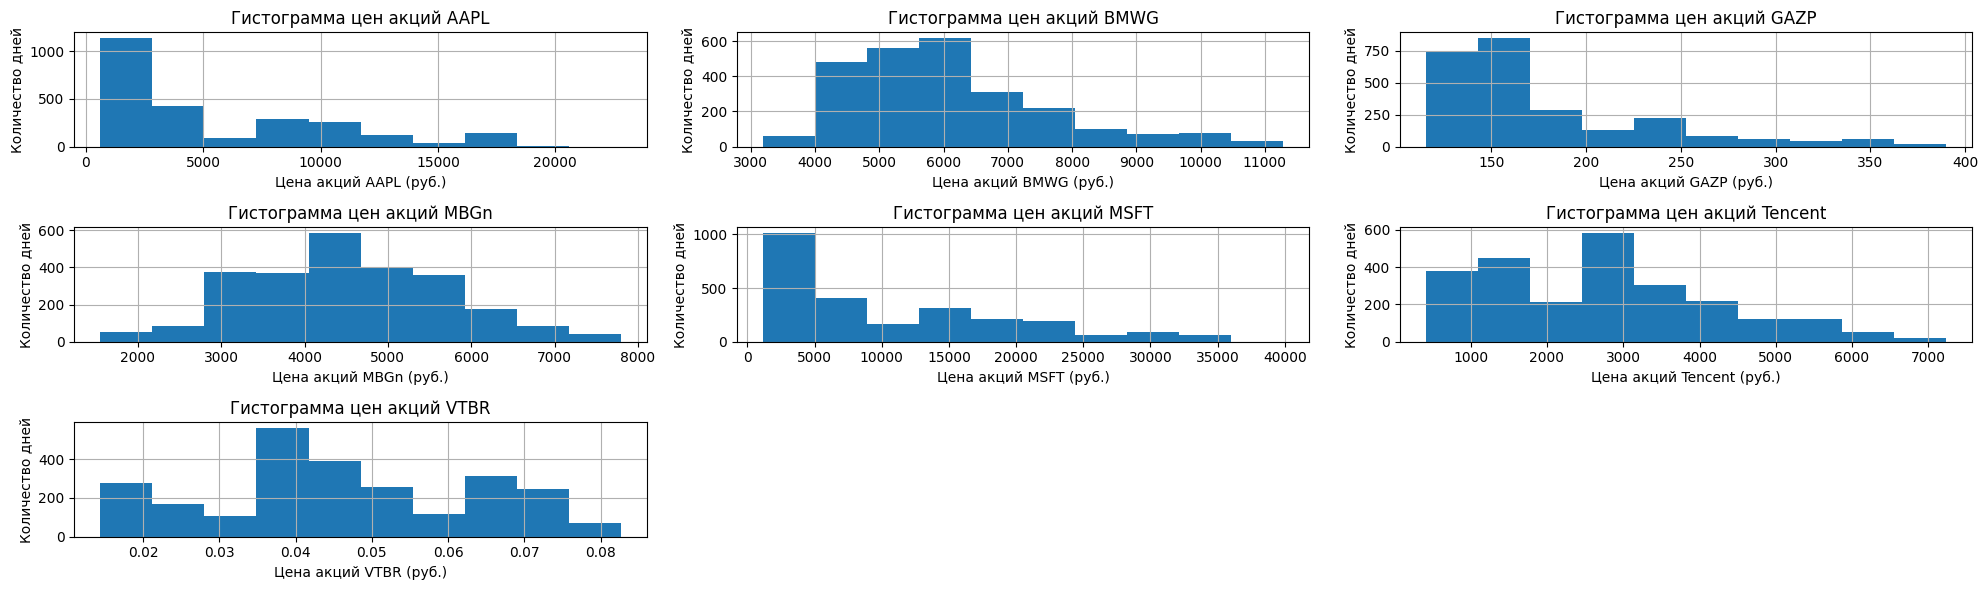

In [106]:
columns = ['AAPL', 'BMWG', 'GAZP', 'MBGn', 'MSFT', 'Tencent', 'VTBR']
ax = df[columns].hist(figsize=(20, 6))

ax[0][0].set_ylabel('Количество дней')
ax[0][1].set_ylabel('Количество дней')
ax[0][2].set_ylabel('Количество дней')
ax[1][0].set_ylabel('Количество дней')
ax[1][1].set_ylabel('Количество дней')
ax[1][2].set_ylabel('Количество дней')
ax[2][0].set_ylabel('Количество дней')

ax[0][0].set_xlabel('Цена акций AAPL (руб.)')
ax[0][1].set_xlabel('Цена акций BMWG (руб.)')
ax[0][2].set_xlabel('Цена акций GAZP (руб.)')
ax[1][0].set_xlabel('Цена акций MBGn (руб.)')
ax[1][1].set_xlabel('Цена акций MSFT (руб.)')
ax[1][2].set_xlabel('Цена акций Tencent (руб.)')
ax[2][0].set_xlabel('Цена акций VTBR (руб.)')

ax[0][0].set_title('Гистограмма цен акций AAPL')
ax[0][1].set_title('Гистограмма цен акций BMWG')
ax[0][2].set_title('Гистограмма цен акций GAZP')
ax[1][0].set_title('Гистограмма цен акций MBGn')
ax[1][1].set_title('Гистограмма цен акций MSFT')
ax[1][2].set_title('Гистограмма цен акций Tencent')
ax[2][0].set_title('Гистограмма цен акций VTBR')
plt.tight_layout();


__ВЫВОДЫ:__
* Похожее на нормальное имеет распределение стоимости акций MBGn, у других
акций распределение стоимостей сильно отличается от нормального
* Если посмотреть в целом на состояние финансового рынка, то большинство акций из числа рассматриваемых значительно выросли в цене за рассматриваемый период в 10 лет (в целом, рынок вырос). Есть небольшие исключения, например, акции VTBR, которые, наоборот, понизились в цене за весь период.
* Наиболее значительным был кризис в конце февраля - марте 2022. Особенно это видно на динамике цен акций в отдельности, например, по акциям VTBR видно, что на открытии рынка цены резко упали в конце февраля 2023

Финансовые продукты описываются двумя характеристикам – __доходностью__ и __риском.__ Доходность – это процентное изменение стоимости за некоторый промежуток времени:

$$
R_t = \left( \frac{P_t}{P_{t-1}} - 1 \right) \cdot 100\%.
$$

Под риском обычно имеют в виду стандартное отклонение.


__з) [5 баллов]__  Рассчитайте процентное изменение цены акций в рублях ото дня ко дню для `df`. Полученную таблицу доходностей сохраните в переменную `df_pct_change`.

__Hint__: С этим поможет метод `pct_change()`, [(ссылка на документацию).](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html)

In [57]:
df.head(10)

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
02/01/2014,653.72500,3780.51916,NaN,2789.90910,1229.99600,418.02048,NaN
03/01/2014,641.42400,3788.67372,NaN,2784.88722,1225.41200,410.55816,NaN
06/01/2014,645.27030,3756.04441,135.47,2785.23886,1199.87730,411.98177,0.04846
07/01/2014,639.27060,3770.02665,NaN,2815.67520,1206.62740,409.79112,NaN
08/01/2014,643.96557,3803.54355,137.33,2801.87619,1186.40952,416.51786,0.04791
09/01/2014,636.36108,3789.88498,138.68,2808.74495,1180.05789,409.84027,0.04812
10/01/2014,628.02806,3751.06280,139.69,2801.90632,1189.39208,410.87424,0.04846
13/01/2014,636.79944,3829.75065,139.08,2861.27657,1164.41424,413.75934,0.04892
14/01/2014,650.03418,3833.93724,137.44,2900.06451,1192.11804,411.17993,0.04911


In [58]:
df_rev_change = df.pct_change(fill_method = 'ffill')

In [59]:
#там, где не было информации о цене в этот день, оставляем Nan
mask = df['AAPL'].isna()
df_rev_change['AAPL'][mask] = np.nan
#df_rev['AAPL'][mask] = np.nan

mask = df['BMWG'].isna()
df_rev_change['BMWG'][mask] = np.nan

mask = df['GAZP'].isna()
df_rev_change['GAZP'][mask] = np.nan

mask = df['MBGn'].isna()
df_rev_change['MBGn'][mask] = np.nan

mask = df['MSFT'].isna()
df_rev_change['MSFT'][mask] = np.nan

mask = df['Tencent'].isna()
df_rev_change['Tencent'][mask] = np.nan

mask = df['VTBR'].isna()
df_rev_change['VTBR'][mask] = np.nan


df_rev_change

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
02/01/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/01/2014,-0.018817,0.002157,NaN,-0.001800,-0.003727,-0.017852,NaN
06/01/2014,0.005997,-0.008612,NaN,0.000126,-0.020838,0.003467,NaN
07/01/2014,-0.009298,0.003723,NaN,0.010928,0.005626,-0.005317,NaN
08/01/2014,0.007344,0.008890,0.013730,-0.004901,-0.016756,0.016415,-0.011350
...,...,...,...,...,...,...,...
25/12/2023,NaN,NaN,-0.006169,NaN,NaN,NaN,0.009576
26/12/2023,-0.006526,NaN,-0.000559,NaN,-0.003483,NaN,-0.001509
27/12/2023,-0.003739,0.000683,-0.007081,0.000202,-0.005823,0.034853,-0.012306


In [60]:
#переводим в проценты
df_rev_change[['AAPL', 'BMWG', 'GAZP', 'MBGn', 'MSFT', 'Tencent', 'VTBR']] = df_rev_change[['AAPL', 'BMWG', 'GAZP', 'MBGn', 'MSFT', 'Tencent', 'VTBR']] * 100
df_rev_change

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
02/01/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/01/2014,-1.881678,0.215699,NaN,-0.180002,-0.372684,-1.785157,NaN
06/01/2014,0.599650,-0.861233,NaN,0.012627,-2.083764,0.346750,NaN
07/01/2014,-0.929796,0.372260,NaN,1.092773,0.562566,-0.531735,NaN
08/01/2014,0.734426,0.889036,1.372998,-0.490078,-1.675569,1.641505,-1.134957
...,...,...,...,...,...,...,...
25/12/2023,NaN,NaN,-0.616941,NaN,NaN,NaN,0.957563
26/12/2023,-0.652606,NaN,-0.055869,NaN,-0.348287,NaN,-0.150895
27/12/2023,-0.373906,0.068282,-0.708075,0.020212,-0.582292,3.485307,-1.230570


In [61]:
df_pct_change = df_rev_change.copy()
#df_pct_change = df.pct_change(fill_method = 'ffill')

__и) [5 баллов]__  Для всех тикеров из таблички `df_pct_change` постройте картинки с динамикой доходностей, гистограмму доходностей и ящики с усами. Ответьте на следующие вопроcы:

- Имеют ли доходности по акциям нормальное распределение?
- Видно ли по ящику с усами, что в данных довольно много выбросов?

__Ответ:__
* Доходности акций сконцентрированы вокруг нуля, 80% всех значений покрывается интервалом от -0.1 до 0.1. Распределение не сильно похоже на нормальное, так как заметна сильная ассиметрия и присутствуют длинные, но очень тонкие хвосты

* В распределении доходностей абсолютно всех акций наблюдается очень много выбросов. Выбросы с наибольшим отклонением в отрицательную сторону имеют акции GAZP и VTBR (наибольшая отрицательная доходность среди всех акций). В положительную сторону - у акций AAPL, MBGn, MSFT, Tencent

__Динамика доходностей__

In [62]:
#Все вместе
fig = px.line(df_pct_change, labels={"value": "Доходность в %"})
fig.update_layout(title_text='Динамика доходности акций во времени', title_x=0.5)

In [63]:
#отдельно y = 'AAPL'
fig = px.line(df_pct_change, y = 'AAPL', labels={"AAPL": "Доходность в %"})
fig.update_layout(title_text='Динамика доходности акций AAPL во времени', title_x=0.5)

In [64]:
#отдельно y = 'BMWG'
fig = px.line(df_pct_change, y = 'BMWG', labels={"BMWG": "Доходность в %"})
fig.update_layout(title_text='Динамика доходности акций BMWG во времени', title_x=0.5)

In [65]:
#отдельно y = 'GAZP'
fig = px.line(df_pct_change, y = 'GAZP', labels={"GAZP": "Доходность в %"})
fig.update_layout(title_text='Динамика доходности акций GAZP во времени', title_x=0.5)

In [66]:
#отдельно y = 'MBGn'
fig = px.line(df_pct_change, y = 'MBGn', labels={"MBGn": "Доходность в %"})
fig.update_layout(title_text='Динамика доходности акций MBGn во времени', title_x=0.5)

In [67]:
#отдельно y = 'MSFT'
fig = px.line(df_pct_change, y = 'MSFT', labels={"MSFT": "Доходность в %"})
fig.update_layout(title_text='Динамика доходности акций MSFT во времени', title_x=0.5)

In [68]:
#отдельно y = 'Tencent'
fig = px.line(df_pct_change, y = 'Tencent', labels={"Tencent": "Доходность в %"})
fig.update_layout(title_text='Динамика доходности акций Tencent во времени', title_x=0.5)

In [69]:
#отдельно y = 'VTBR'
fig = px.line(df_pct_change, y = 'VTBR', labels={"VTBR": "Доходность в %"})
fig.update_layout(title_text='Динамика доходности акций VTBR во времени', title_x=0.5)

__Гистограмма доходностей__

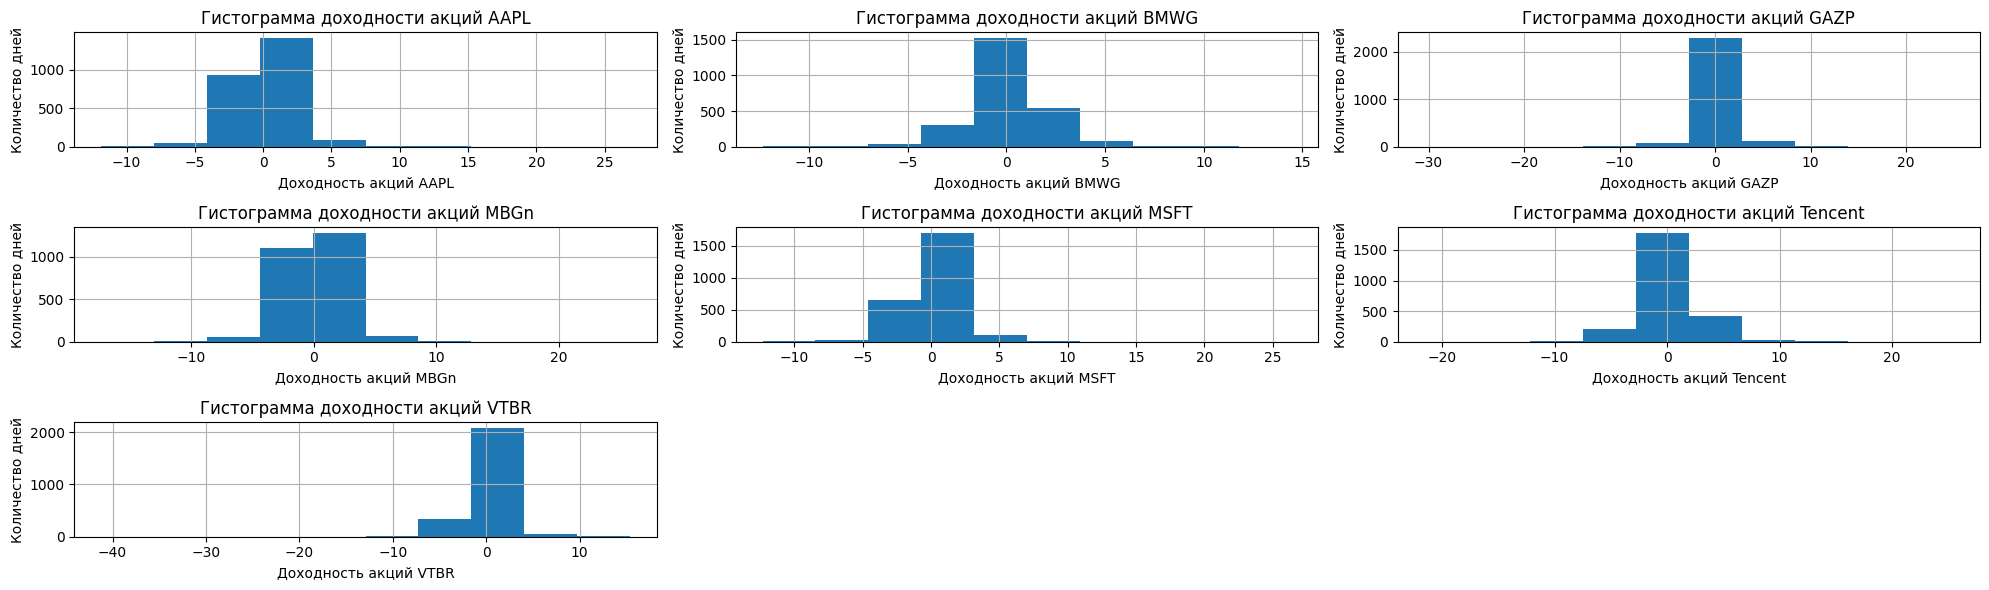

In [70]:
columns = ['AAPL', 'BMWG', 'GAZP', 'MBGn', 'MSFT', 'Tencent', 'VTBR']
ax = df_pct_change[columns].hist(figsize=(20, 6))

ax[0][0].set_ylabel('Количество дней')
ax[0][1].set_ylabel('Количество дней')
ax[0][2].set_ylabel('Количество дней')
ax[1][0].set_ylabel('Количество дней')
ax[1][1].set_ylabel('Количество дней')
ax[1][2].set_ylabel('Количество дней')
ax[2][0].set_ylabel('Количество дней')

ax[0][0].set_xlabel('Доходность акций AAPL')
ax[0][1].set_xlabel('Доходность акций BMWG')
ax[0][2].set_xlabel('Доходность акций GAZP')
ax[1][0].set_xlabel('Доходность акций MBGn')
ax[1][1].set_xlabel('Доходность акций MSFT')
ax[1][2].set_xlabel('Доходность акций Tencent')
ax[2][0].set_xlabel('Доходность акций VTBR')

ax[0][0].set_title('Гистограмма доходности акций AAPL')
ax[0][1].set_title('Гистограмма доходности акций BMWG')
ax[0][2].set_title('Гистограмма доходности акций GAZP')
ax[1][0].set_title('Гистограмма доходности акций MBGn')
ax[1][1].set_title('Гистограмма доходности акций MSFT')
ax[1][2].set_title('Гистограмма доходности акций Tencent')
ax[2][0].set_title('Гистограмма доходности акций VTBR')
plt.tight_layout();

__Логарифмированное__

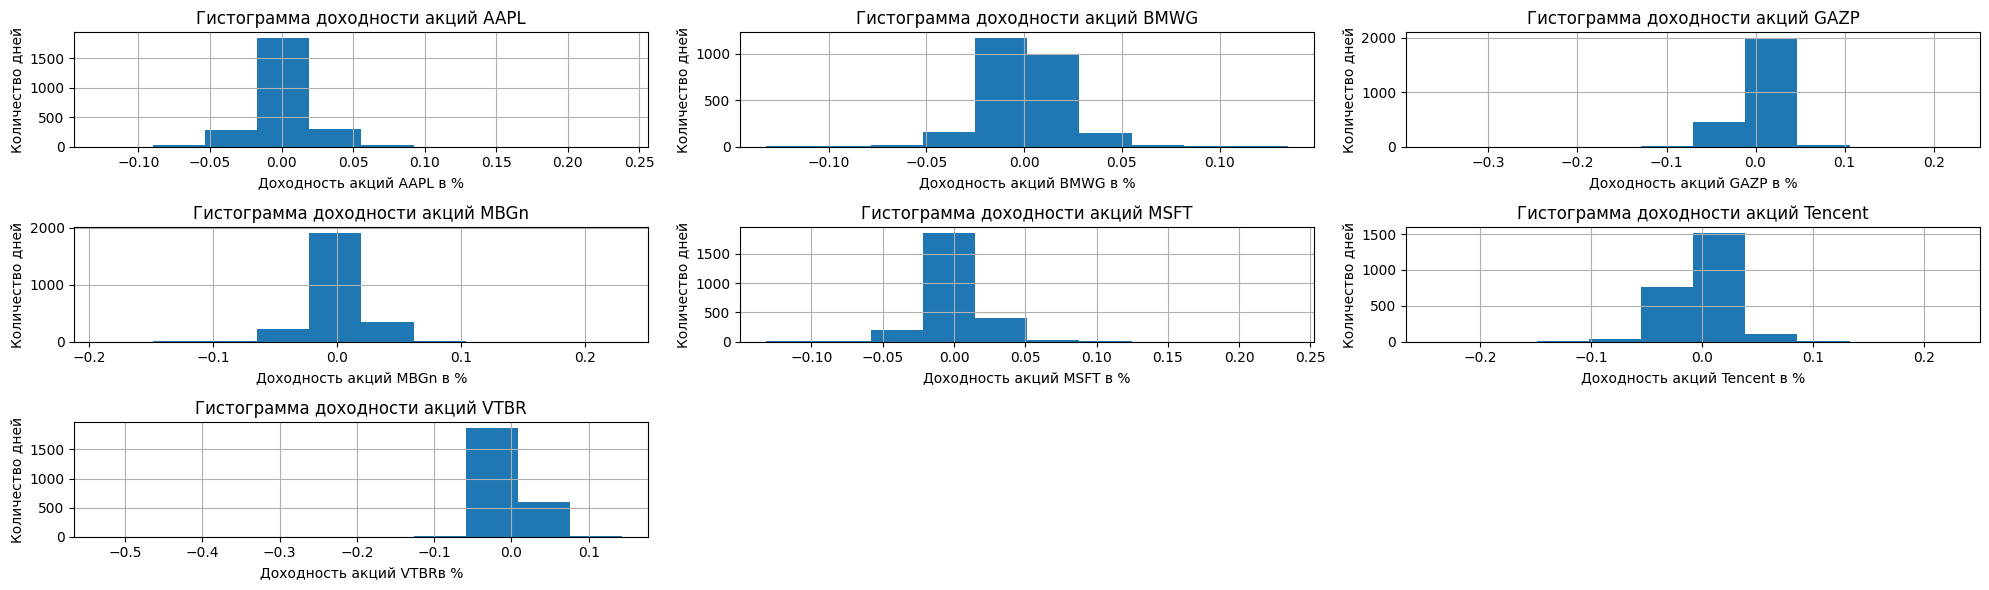

In [109]:
columns = ['AAPL', 'BMWG', 'GAZP', 'MBGn', 'MSFT', 'Tencent', 'VTBR']
df_pct_change_log = df_pct_change[columns].apply(lambda x: np.log(x + 1))
#df_pct_change_log['Дата'] = df_pct_change['Дата']
ax = df_pct_change_log[columns].hist(figsize=(20, 6))

ax[0][0].set_ylabel('Количество дней')
ax[0][1].set_ylabel('Количество дней')
ax[0][2].set_ylabel('Количество дней')
ax[1][0].set_ylabel('Количество дней')
ax[1][1].set_ylabel('Количество дней')
ax[1][2].set_ylabel('Количество дней')
ax[2][0].set_ylabel('Количество дней')

ax[0][0].set_xlabel('Доходность акций AAPL в %')
ax[0][1].set_xlabel('Доходность акций BMWG в %')
ax[0][2].set_xlabel('Доходность акций GAZP в %')
ax[1][0].set_xlabel('Доходность акций MBGn в %')
ax[1][1].set_xlabel('Доходность акций MSFT в %')
ax[1][2].set_xlabel('Доходность акций Tencent в %')
ax[2][0].set_xlabel('Доходность акций VTBRв %')

ax[0][0].set_title('Гистограмма доходности акций AAPL')
ax[0][1].set_title('Гистограмма доходности акций BMWG')
ax[0][2].set_title('Гистограмма доходности акций GAZP')
ax[1][0].set_title('Гистограмма доходности акций MBGn')
ax[1][1].set_title('Гистограмма доходности акций MSFT')
ax[1][2].set_title('Гистограмма доходности акций Tencent')
ax[2][0].set_title('Гистограмма доходности акций VTBR')
plt.tight_layout();


__Ящики с усами__

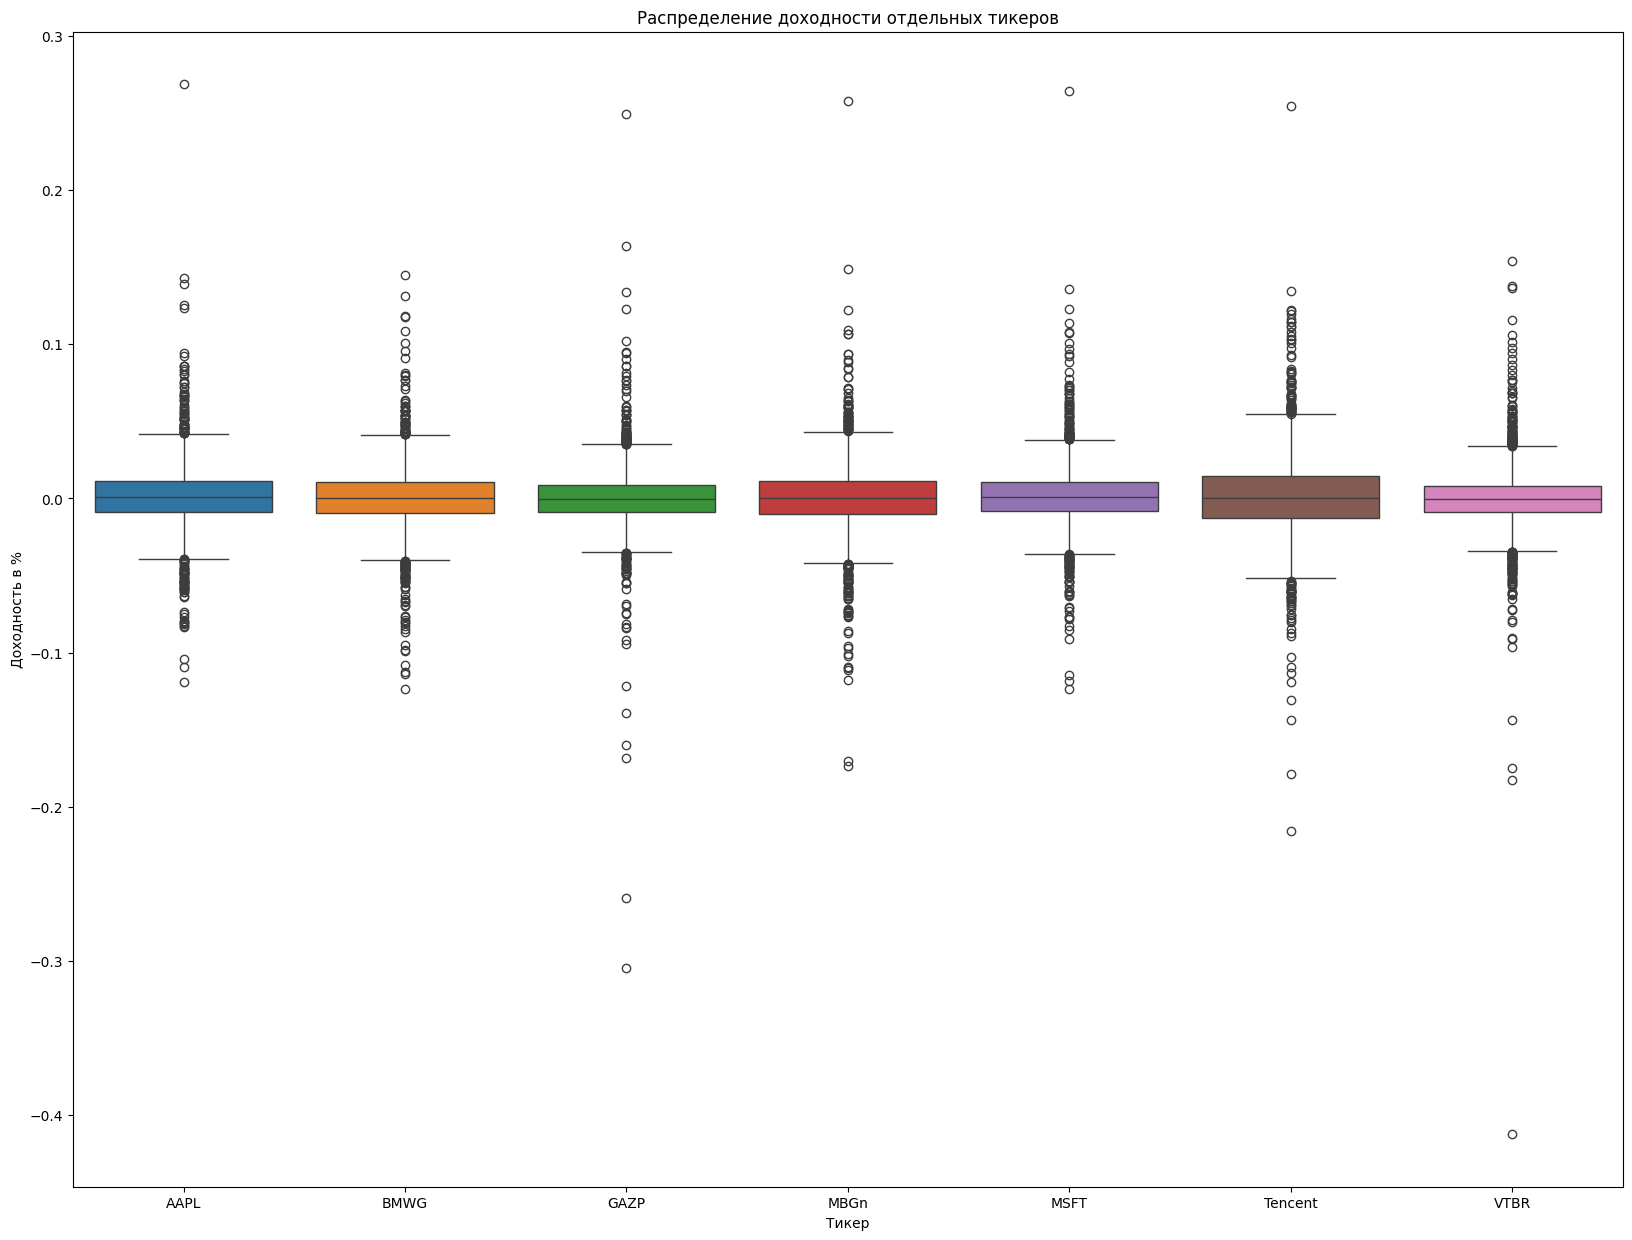

In [105]:
plt.figure(figsize=(20, 15))
plt.title('Распределение доходности отдельных тикеров')
plt.xlabel('Тикер')
plt.ylabel('Доходность в %')
sns.boxplot(data = df_pct_change);

__к) [5 баллов]__  В пункте __д)__ мы нашли даты, в которые наблюдались наибольшие измения стоимости ценых бумаг. При расчётах мы проигнорировали колебания курсов валют.

Давайте посмотрим, каким бы было колебание цен акций в абсолютном выражении для дат из таблички `top_5_diff`, если бы мы учли изменения курсов валют.

В таблице `df_pct_change` все доходности измерены в рублях. Посчитайте для этой таблицы построчное среднее для абсолютных значений изменений.

In [73]:
df_pct_change.head()

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
02/01/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/01/2014,-1.881678,0.215699,NaN,-0.180002,-0.372684,-1.785157,NaN
06/01/2014,0.599650,-0.861233,NaN,0.012627,-2.083764,0.346750,NaN
07/01/2014,-0.929796,0.372260,NaN,1.092773,0.562566,-0.531735,NaN
08/01/2014,0.734426,0.889036,1.372998,-0.490078,-1.675569,1.641505,-1.134957


In [74]:
#берем модуль от процентных изменений для подсчета абсолютных значений
df_pct_change['AAPL'] = df_pct_change['AAPL'].map(np.abs)
df_pct_change['BMWG'] = df_pct_change['BMWG'].map(np.abs)
df_pct_change['GAZP'] = df_pct_change['GAZP'].map(np.abs)
df_pct_change['MBGn'] = df_pct_change['MBGn'].map(np.abs)
df_pct_change['MSFT'] = df_pct_change['MSFT'].map(np.abs)
df_pct_change['Tencent'] = df_pct_change['Tencent'].map(np.abs)
df_pct_change['VTBR'] = df_pct_change['VTBR'].map(np.abs)
df_pct_change.head()

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
02/01/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/01/2014,1.881678,0.215699,NaN,0.180002,0.372684,1.785157,NaN
06/01/2014,0.599650,0.861233,NaN,0.012627,2.083764,0.346750,NaN
07/01/2014,0.929796,0.372260,NaN,1.092773,0.562566,0.531735,NaN
08/01/2014,0.734426,0.889036,1.372998,0.490078,1.675569,1.641505,1.134957


In [75]:
#подсчет построчных средних
mean_series = df_pct_change.mean(axis = 1)
mean_series.head()

Дата
02/01/2014         NaN
03/01/2014    0.887044
06/01/2014    0.780805
07/01/2014    0.697826
08/01/2014    1.134081
dtype: float64

Оставьте только те даты, которые встречаются в `top_5_diff`, и добавить их в качестве нового столбца `'Изм. (RUB) %'`

__Hint__: Чтобы выделить список необходимых дат из таблички `top_5_diff`, можно воспользоваться методом `to_list()` применительно к столбцу `'Дата'`. Такой список можно дальше использовать при обращении к строкам в `'[...]'`.

In [76]:
top_5_diff.head()

,Дата,Изм. %
0,24/02/2022,13.081429
1,29/02/2016,11.840000
2,24/03/2020,10.795714
3,12/03/2020,10.615714
4,21/02/2022,9.128000


In [77]:
dates = top_5_diff['Дата'].to_list()

In [78]:
top_5_diff = top_5_diff.set_index('Дата')
top_5_diff['Изм. (RUB) %'] = mean_series[dates]

top_5_diff

,Изм. %,Изм. (RUB) %
Дата,,
24/02/2022,13.081429,12.677837
29/02/2016,11.840000,1.631587
24/03/2020,10.795714,9.703503
12/03/2020,10.615714,9.195150
21/02/2022,9.128000,7.613740


__л) [2 балла]__  Проинтерпретируете уменьшение/увеличение процентного изменения стоимости акций при пересчете по курсу в рубли.

__Ответ:__ Разница в доходности обусловлена изменением курсов иностранной валюты к рублю. Например, c 23.02.2022 на 24.02.2022 рубль подешевел относительно евро и доллара, поэтому доходность в рублях была чуть потеряна из-за обесценения рубля.
Единственная слишком сильняа разница в доходности в представленной таблице обусловлена неккоректностью изначальных данных - 70% изменение у акции AAPL (из исходных данных), что слишком сильно изменило среднее.

## 3 Составляем портфель


Финансовые продукты описываются двумя характеристиками: __доходностью__ и __риском__.

Доходность — это процентное изменение стоимости за некоторый промежуток времени. Под риском, как правило, понимается стандартное отклонение доходности акций.

Однако когда речь идет о нескольких акциях в портфеле, то необходимо учитывать, как связана динамика цен на эти акции: падение доходности одной из акций может быть компенсировано ростом другой. Такой портфель будет предпочтительнее, поскольку предлагает меньшие риски для инвестора.

Осталось найти то самое сладкое сочетание активов... Для поиска оптимальных весов активов в портфеле обычно решается __задача оптимизации.__

Мы поступим проще:

- Будем рассматривать портфель, состоящий всего из 2 тикеров: `'AAPL'` и `'Tencent'`.
- Наилучшее сочетание весов будем искать неоптимальным способом, тупо перебирая различные варианты.

Пусть мы вкладываем долю нашего бюджета $w$ в первую ценную бумагу, а долю $(1 - w)$ во вторую. Тогда ожидаемая доходность порфеля составит

$$
\mathbb{E}(R) = w \cdot \mathbb{E}(R_1)  + (1 - w) \cdot \mathbb{E}(R_2).
$$

Дисперсия портфеля будет равна

$$
\text{Var}(R) = w^2 \cdot \text{Var}(R_1)  + (1 - w)^2 \cdot \text{Var}(R_2) + 2 \cdot w \cdot \text{Cov}(R_1, R_2).
$$

Ковариацию, по её определению, можно переписать как

$$
\text{Cov}(R_1, R_2) = \text{Corr}(R_1, R_2) \cdot \sigma(R_1) \cdot \sigma(R_2),
$$

где $\sigma(R_i) = \sqrt{ \text{Var}(R_i)}$.


Для начала создадим веса, которые будем рассматривать.

__а) [2 балла]__ С помощью функции `np.arange()` создайте `array` от $0$ до $1$ с шагом $0.01$ [(ссылка на документацию).](https://numpy.org/doc/stable/reference/generated/numpy.arange.html)

In [83]:
w = np.arange(start = 0, stop = 1 + 0.01, step = 0.01)
w

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

Теперь запишем необходимые характеристики акций в соответствующие переменные:

__б) [3 балла]__ В переменные `r1` и `r2` сохраните среднюю доходность акций `'AAPL'` и `'Tencent'` из `df_pct_change`. Убедитесь, что доходности представлены не в процентах, а в виде чисел. Например не $10\%$, а $0.1$.

Кроме того, поскольку стандартной мерой доходности является годовая доходность, преобразуем среднюю ежедневную доходность в годовую, используя формулу сложного процента для полученных значений:

$$
r_{\text{год}} = (1 + r_{\text{день}})^{252} - 1,
$$

где:
- $r_{\text{год}}$ - ожидаемая годовая доходность,
- $r_{\text{день}}$ - средняя ежедневная доходность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

In [85]:
#восстанавливаем таблицу процентных изменений
df_rev_change = df.pct_change(fill_method = 'ffill')
mask = df['AAPL'].isna()
df_rev_change['AAPL'][mask] = np.nan
#df_rev['AAPL'][mask] = np.nan

mask = df['BMWG'].isna()
df_rev_change['BMWG'][mask] = np.nan

mask = df['GAZP'].isna()
df_rev_change['GAZP'][mask] = np.nan

mask = df['MBGn'].isna()
df_rev_change['MBGn'][mask] = np.nan

mask = df['MSFT'].isna()
df_rev_change['MSFT'][mask] = np.nan

mask = df['Tencent'].isna()
df_rev_change['Tencent'][mask] = np.nan

mask = df['VTBR'].isna()
df_rev_change['VTBR'][mask] = np.nan


df_pct_change = df_rev_change

In [ ]:
#df_rev_change = df.pct_change(fill_method = 'ffill')
#df_pct_change = df_rev_change

In [98]:
df

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
02/01/2014,653.72500,3780.51916,NaN,2789.90910,1229.99600,418.02048,NaN
03/01/2014,641.42400,3788.67372,NaN,2784.88722,1225.41200,410.55816,NaN
06/01/2014,645.27030,3756.04441,135.47,2785.23886,1199.87730,411.98177,0.048460
07/01/2014,639.27060,3770.02665,NaN,2815.67520,1206.62740,409.79112,NaN
08/01/2014,643.96557,3803.54355,137.33,2801.87619,1186.40952,416.51786,0.047910
...,...,...,...,...,...,...,...
25/12/2023,NaN,NaN,161.09,NaN,NaN,NaN,0.023195
26/12/2023,17694.96300,NaN,161.00,NaN,34341.33560,NaN,0.023160
27/12/2023,17628.80050,10218.61160,159.86,6378.48993,34141.36890,3343.33500,0.022875


In [96]:
df_rev_change = df.pct_change(fill_method = 'ffill')
df_rev_change

,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
02/01/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/01/2014,-0.018817,0.002157,NaN,-0.001800,-0.003727,-0.017852,NaN
06/01/2014,0.005997,-0.008612,NaN,0.000126,-0.020838,0.003467,NaN
07/01/2014,-0.009298,0.003723,0.000000,0.010928,0.005626,-0.005317,0.000000
08/01/2014,0.007344,0.008890,0.013730,-0.004901,-0.016756,0.016415,-0.011350
...,...,...,...,...,...,...,...
25/12/2023,0.000000,0.000000,-0.006169,0.000000,0.000000,0.000000,0.009576
26/12/2023,-0.006526,0.000000,-0.000559,0.000000,-0.003483,0.000000,-0.001509
27/12/2023,-0.003739,0.000683,-0.007081,0.000202,-0.005823,0.034853,-0.012306


In [87]:
#средняя доходность акций
r1 = df_pct_change['AAPL'].mean()
r2 = df_pct_change['Tencent'].mean()
print(r1, r2)

0.0015284814724004173 0.0011980119404542413


In [88]:
r1 = (1 + r1)**252 - 1
r2 = (1 + r2)**252 - 1
print(r1, r2)

0.4694427722820249 0.3521802827870626


__в) [3 балла]__ Аналогично сохраните стандартные отклонения доходности этих акций в `sd1` и `sd2`. Преобразуйте эти значения из дневных в годовые:

$$
\sigma_{\text{год}} = \sigma_{\text{день}} \times \sqrt{252}
$$

Где:
- $\sigma_{\text{год}}$ - годовая волатильность,
- $\sigma_{\text{день}}$ - ежедневная волатильность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

Эта формула основана на предположении, что ежедневные доходности распределены независимо и одинаково. В реальности рыночные условия могут влиять на точность этого преобразования, но это общепринятый метод для оценки годовой волатильности на основе ежедневных данных.

In [89]:
#стандартные отклонения
sd1 = df_pct_change['AAPL'].std()
sd2 = df_pct_change['Tencent'].std()
print(sd1, sd2)

0.021259088471205546 0.0265303552209151


In [90]:
sd1 = sd1 * (252) ** (1/2)
sd2 = sd2 * (252) ** (1/2)
print(sd1, sd2)

0.3374775671683812 0.4211563326524726


__в) [1 балл]__ В переменную `rho` сохраните корреляцию между акциями.

In [91]:
df_pct_change['AAPL'].corr(df_pct_change['Tencent'])

0.2712911304135506

In [92]:
rho = df_pct_change['AAPL'].corr(df_pct_change['Tencent'])

Теперь посчитаем доходность и волатильность портфеля, используя соответствующие формулы

In [93]:
r_p2 = w * r1 +(1 - w) * r2
sd_p2 = np.sqrt(w**2 * sd1**2 + (1 - w)**2 * sd2**2 + 2 * w * (1 - w) * rho * sd1 * sd2)

__г) [5 баллов]__ Постройте линейный график в осях (`sd_p2`, `r_p2`)

__Hint:__ Можно сделать с помощью `plt.plot(x, y)`

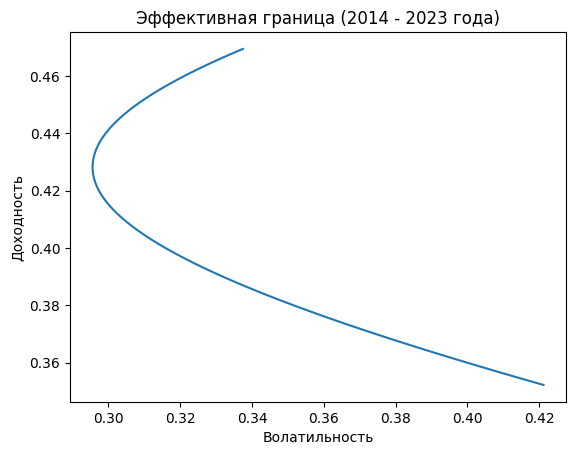

In [119]:
plt.title('Эффективная граница (2014 - 2023 года)')
plt.xlabel('Волатильность')
plt.ylabel('Доходность')
plt.plot(sd_p2,r_p2);

Получившаяся у вас картинка должна быть похожа на такую:

<center>
<img src="https://investprofit.info/wp-content/uploads/2018/08/Frontier1.png" height="450">
</center>

В портфельной теории Марковица эта кривая называется эффективной границей (или кривой эффективностию). Её можно поделить на три зоны:

- **Эффективная граница (Efficient Frontier)** — это часть кривой, которая лежит выше портфеля с минимальной дисперсией (риском). Портфели на этом участке предлагают наилучшее сочетание риска и доходности. Другими словами, для любого данного уровня риска, портфели на эффективной границе предлагают максимальную возможную доходность.
- **Портфели ниже эффективной границы** считаются неэффективными, так как для того же уровня риска можно добиться большей доходности.
- **Портфели выше эффективной границы** обычно не существуют, так как они предполагали бы получение более высокой доходности при том же уровне риска.

Найдем портфель с минимальной дисперсией (риском).

__д) [3 балла]__ Для этого сначала создадим табличку со столбцами `'Вес'`, `'Риск'` и `'Доходность'` (содержащими `w`, `sd_p2` и `r_p2` соответственно)

In [110]:
d = {'Вес': w,
    'Риск': sd_p2,
    'Доходность': r_p2}

In [111]:
df_r = pd.DataFrame(data = d)

In [112]:
df_r.head()

,Вес,Риск,Доходность
0,0.00,0.337478,0.469443
1,0.01,0.335270,0.468270
2,0.02,0.333112,0.467098
3,0.03,0.331004,0.465925
4,0.04,0.328949,0.464752


__е) [3 балла]__ Теперь найдем портфель с минимальным риском и запишем его в переменную `min_sd_p`, а само значение минимального риска в `min_sd`

In [114]:
#значение минимального риска
min_sd = df_r['Риск'].min()
min_sd

0.2956203833483885

In [144]:
#портфель с минимальным весом
min_sd_p = df_r[df_r['Риск'] == min_sd]
min_sd_p

,Вес,Риск,Доходность,Sharp
35,0.35,0.29562,0.428401,1.049998


In [143]:
#Вес портфеля
weight = df_r[df_r['Риск'] == min_sd]['Вес'].to_numpy()[0]
weight

0.35000000000000003

__ж) [3 балла]__ Выберем множество эффективных портфелей из `df_r`, тех, чья доходность и риск выше, чем у `min_sd_p` и сохраним их в `df_eff_p`

In [132]:
#доходность портфеля с мин риском
ret = df_r[df_r['Риск'] == min_sd]['Доходность'].to_numpy()[0]
ret

0.428400900958788

In [133]:
#min_sd_p['Доходность'].to_numpy()[0]

df_eff_p = df_r[(df_r['Риск'] > min_sd) & (df_r['Доходность'] > ret)]

__з) [3 балла]__ А теперь на основе `df_eff_p` построим эффективную границу, о которой шла речь раньше (часть кривой выше портфеля с наименьшей волатильностью)

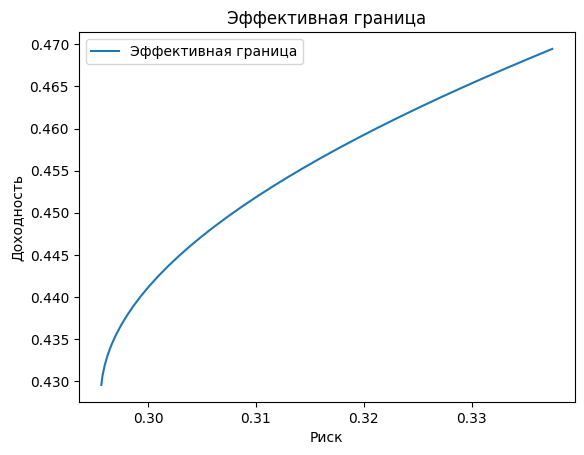

In [138]:
df_eff_p.plot.line(x = 'Риск', y = 'Доходность', label = 'Эффективная граница')
plt.title('Эффективная граница')
plt.xlabel('Риск')
plt.ylabel('Доходность');

Выше мы говорили, что для поиска оптимального портфеля необходимо решать задачу оптимизации. Целевую функцию для её решения можно определить по-разному. Выше мы занимались минимизацией риска и нашли `min_sd_p`.

Кроме минимизации риска можно попытаться максимизировать **коэффициент Шарпа.** Он рассчитывается по формуле

$$
SR = \frac{r_{p} - r_{f}}{\sigma_{p}},
$$

где $r_{p}$  —  ожидаемая доходность портфеля, $r_{f}$  —  безрисковая ставка доходности, $\sigma_{p}$ — стандартное отклонение доходности портфеля.

Коэффициент Шарпа отражает премию за принятый риск. Любая инвестиционная стратегия, демонстрирующая более крутой наклон кривой Шарпа, предлагает более высокую ожидаемую доходность для данного уровня риска. Следовательно, более высокий коэффициент Шарпа всегда предпочтительнее, независимо от того, какой уровень риска вы готовы принять.

В качестве безрисковой ставки доходности выберем доходность российских государственных облигаций сроком 10 лет (можно посмотреть [тут](https://cbr.ru/hd_base/zcyc_params/))

In [139]:
r_f = 11.8/100

__и) [3 балла]__ Теперь у нас есть возможность рассчитать коэффициент Шарпа для кадждого портфеля в `df_r`. Для этого необходимо вычесть из доходности портфеля безрисковую ставку (`r_f`) и разделить на волатильность (риск) портфеля. Сохраните полученные значения в столбец `'Sharp'` таблицы `df_r`

In [148]:
df_r['Sharp'] = (df_r['Доходность'] - r_f) / df_r['Риск']
df_r

,Вес,Риск,Доходность,Sharp
0,0.00,0.337478,0.469443,1.041381
1,0.01,0.335270,0.468270,1.044741
2,0.02,0.333112,0.467098,1.047989
3,0.03,0.331004,0.465925,1.051119
4,0.04,0.328949,0.464752,1.054123
...,...,...,...,...
96,0.96,0.408179,0.356871,0.585211
97,0.97,0.411384,0.355698,0.577802
98,0.98,0.414615,0.354526,0.570470
99,0.99,0.417873,0.353353,0.563216


__и) [3 балла]__ Определите портфель с максимальным коэффициентом Шарпа, сохраните его в переменную `max_sharp_p`, а значение самого коэффициента - в переменную `max_sharp`

In [149]:
#маскимальный коэффициент Шарпа
max_sharp = df_r['Sharp'].max()
max_sharp

1.0794525673053932

In [152]:
#портфель с максимальным коэффициентом Шарпа
max_sharp_p = df_r[df_r['Sharp'] == max_sharp]
max_sharp_p

,Вес,Риск,Доходность,Sharp
20,0.2,0.303849,0.44599,1.079453


Рассмотрим прямую в осях (Риск - Доходность), выраженную формулой

$$ r = max\_sharp \cdot \sigma + r_f $$

Для того, чтобы ее провести, нам необходимо задать хотя бы 2 точки. Чтобы построенный график хорошо выглядел, рассмотрим $\sigma$, равную:

1. наименьшему значению риска портфелей на эффективной кривой (`min_sd`)
2. значению риска, соответствующего портфелю с наибольшим значением коэффициента Шарпа (из `max_sharp_p`)

__к) [3 балла]__ В переменную `sigma` сохраните `numpy.array` с двумя перечисленными выше значениями

In [153]:
sigma = np.array([min_sd, max_sharp_p['Риск'].to_numpy()[0]])
sigma

array([0.29562038, 0.30384871])

__л) [3 балла]__ В переменную `r` сохраните значения доходности, находящиеся на указанной прямой, для значений риска из `sigma` (необходимо использовать формулу прямой)

In [154]:
first = max_sharp * min_sd + r_f
second = max_sharp * max_sharp_p['Риск'].to_numpy()[0] + r_f

In [155]:
r = np.array([first, second])
r

array([0.43710818, 0.44599027])

__м) [5 баллов]__ Теперь построим эффективную границу, что мы уже делали ранее, и проведем указанную прямую (вернее ее часть).

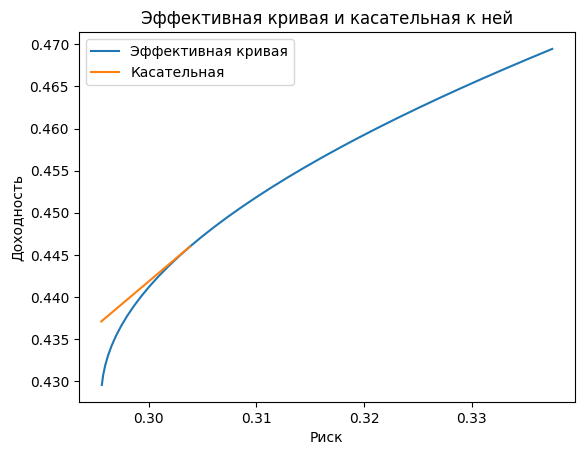

In [158]:
df_eff_p.plot.line(x = 'Риск', y = 'Доходность', label = 'Эффективная кривая')
plt.plot(sigma, r, label = 'Касательная')
plt.title('Эффективная кривая и касательная к ней')
plt.xlabel('Риск')
plt.legend()
plt.ylabel('Доходность');

Полученная прямая является касательной к эффективной кривой, а точка ее касания представляет собой так называемый тангенциальный портфель.

Каждая точка на прямой Шарпа представляет собой портфель, состоящий из комбинации безрискового актива (в нашем случае, государственных облигаций) и рыночного портфеля (здесь, сочетание двух акций).

Все портфели на прямой Шарпа считаются эффективными в смысле оптимального соотношения риска и доходности. Это означает, что для любого данного уровня риска портфель на этой линии предоставляет максимально возможную доходность.

__н) [3 балла]__ Проинтерпретируйте численное значение наибольшего коэффициента Шарпа (`max_sharp`)

In [159]:
max_sharp

1.0794525673053932

**Ответ:** Так как показатель больше единицы, а это соответствует норме для выбора эффективного портфеля, то это означает, что данный портфель принесет хорошую доходность с высокой вероятностью и приемлемым риском (довольно стабильный портфель). В целом, данный портфель можно считать хорошим вариантом, так как результата выше 1 добиться сложно, поэтому результат на уровне 1 уже считается хорошим и приемлемым.

Таким образом, мы немного углубились в портфельную теорию и рассмотрели 2 основных метода оптимизации структуры портфеля:
- поиск наименее волатильного (рискового) портфеля
- поиск портфеля с оптимальным соотношением доходности и риска.